In [1]:
import json
import re
from os.path import join
import os

import pandas as pd
import numpy as np
from tqdm import tqdm
import xgboost as xgb

import cfbd

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

with open('../config.json') as f:
    configuration = cfbd.Configuration(
        access_token = json.load(f)['CFBD_API_KEY']
    )

## 1. Load the Data

In [2]:
YEARS = range(2013, 2025)
DATA_DIR = '../data'

In [3]:
def convert_to_snake_case(cols):
    cols_new = []
    for c in cols:
        s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', c)
        cols_new.append(re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1).lower())
    return cols_new

In [4]:
# Load games data
all_dfs = []
id_cols = ['id', 'season', 'week', 'season_type', 'completed', 'neutral_site', 'venue_id']
home_cols = ['home_id', 'home_team', 'home_conference', 'home_division', 'home_points', 'home_pregame_elo']
away_cols = ['away_id', 'away_team', 'away_conference', 'away_division', 'away_points', 'away_pregame_elo']

games_dir = join(DATA_DIR, 'games')
if not os.path.exists(games_dir):
    os.makedirs(games_dir)


for year in YEARS:
    file_path = join(games_dir, f'{year}.parquet')
    if os.path.exists(file_path):
        print(f'Reading {file_path} from cached data')
        df_tmp = pd.read_parquet(file_path)
    else:
        print(f'Fetching {year} games data from CFBD API')
        with cfbd.ApiClient(configuration) as api_client:
            api_instance = cfbd.GamesApi(api_client)
            data = api_instance.get_games(year=year)
        df_tmp = pd.DataFrame([val.to_dict() for val in data])
        df_tmp.columns = convert_to_snake_case(df_tmp.columns)
        df_tmp = df_tmp[id_cols + [
                            'home_id','home_team','home_conference','home_classification','home_points','home_pregame_elo',
                            'away_id','away_team','away_conference','away_classification','away_points','away_pregame_elo']]
        df_tmp['season_type'] = df_tmp['season_type'].apply(lambda x: x.value)
        df_tmp = df_tmp.assign(
            home_division=df_tmp['home_classification'].apply(lambda x: x.value if x is not None else None),
            away_division=df_tmp['away_classification'].apply(lambda x: x.value if x is not None else None)
        ).drop(columns=['home_classification','away_classification'])
        df_tmp = df_tmp[id_cols + home_cols + away_cols]
        df_tmp.to_parquet(file_path)
    all_dfs.append(df_tmp)
del df_tmp

df_games = pd.concat(all_dfs, ignore_index=True).reset_index(drop=True)
df_games.head()

Reading ../data/games/2013.parquet from cached data
Reading ../data/games/2014.parquet from cached data
Reading ../data/games/2015.parquet from cached data
Reading ../data/games/2016.parquet from cached data
Reading ../data/games/2017.parquet from cached data
Reading ../data/games/2018.parquet from cached data
Reading ../data/games/2019.parquet from cached data
Reading ../data/games/2020.parquet from cached data
Reading ../data/games/2021.parquet from cached data
Reading ../data/games/2022.parquet from cached data
Reading ../data/games/2023.parquet from cached data
Reading ../data/games/2024.parquet from cached data


,id,season,week,season_type,completed,neutral_site,venue_id,home_id,home_team,home_conference,home_division,home_points,home_pregame_elo,away_id,away_team,away_conference,away_division,away_points,away_pregame_elo
0,332412309,2013,1,regular,True,False,3696.0,2309,Kent State,Mid-American,fbs,17.0,1530.0,2335,Liberty,Big South,fcs,10.0,1467.0
1,332412579,2013,1,regular,True,False,3994.0,2579,South Carolina,SEC,fbs,27.0,1759.0,153,North Carolina,ACC,fbs,10.0,1638.0
2,332410154,2013,1,regular,True,False,3630.0,154,Wake Forest,ACC,fbs,31.0,NaN,2506,Presbyterian,Big South,fcs,7.0,NaN
3,332412623,2013,1,regular,True,False,3878.0,2623,Missouri State,MVFC,fcs,17.0,NaN,2466,Northwestern State,Southland,fcs,23.0,NaN
4,332412230,2013,1,regular,True,True,3681.0,2230,Fordham,Patriot,fcs,51.0,NaN,227,Rhode Island,CAA,fcs,26.0,NaN


In [5]:
# Load plays data
all_dfs = []
cols = ['id', 'drive_id', 'game_id', 'drive_number', 'play_number', 'offense',
       'offense_conference', 'offense_score', 'defense', 'home', 'away',
       'defense_conference', 'defense_score', 'period', 'offense_timeouts',
       'defense_timeouts', 'yardline', 'yards_to_goal', 'down', 'distance',
       'yards_gained', 'scoring', 'play_type', 'play_text', 'ppa',
       'clock_minutes', 'clock_seconds']

plays_dir = join(DATA_DIR, 'plays')
if not os.path.exists(plays_dir):
    os.makedirs(plays_dir)

for year in YEARS:
    season_file_path = join(plays_dir, f'{year}.parquet')
    
    if os.path.exists(season_file_path):
        print(f'Reading {season_file_path} from cached data')
        df_season_plays = pd.read_parquet(season_file_path)
    else:
        print(f'Fetching all weeks plays data for {year} from CFBD API')
        weeks = df_games.query('season == @year').week.unique().tolist()

        season_dfs = []
        for week in weeks:
            print(f'Fetching {year} plays data for week {week} from CFBD API')
            with cfbd.ApiClient(configuration) as api_client:
                api_instance = cfbd.PlaysApi(api_client)
                data = api_instance.get_plays(year=year, week=week)
            df_tmp = pd.DataFrame([val.to_dict() for val in data])
            if df_tmp.empty:
                print(f'No plays data for {year} week {week}')
                continue
            df_tmp.columns = convert_to_snake_case(df_tmp.columns)

            df_tmp['clock_minutes'] = df_tmp['clock'].apply(lambda x: x['minutes'])
            df_tmp['clock_seconds'] = df_tmp['clock'].apply(lambda x: x['seconds'])
            df_tmp.drop(columns=['clock'], inplace=True)

            df_tmp = df_tmp[cols]
            season_dfs.append(df_tmp)
        
        df_season_plays = pd.concat(season_dfs, ignore_index=True).reset_index(drop=True)
        
        df_season_plays.to_parquet(season_file_path)
        print(f'Saved plays data for {year} to {season_file_path}')
        del season_dfs, df_tmp

    all_dfs.append(df_season_plays)

    del df_season_plays
    
df_plays = pd.concat(all_dfs, ignore_index=True).reset_index(drop=True)
df_plays.head()

Reading ../data/plays/2013.parquet from cached data
Reading ../data/plays/2014.parquet from cached data
Reading ../data/plays/2015.parquet from cached data
Reading ../data/plays/2016.parquet from cached data
Reading ../data/plays/2017.parquet from cached data
Reading ../data/plays/2018.parquet from cached data
Reading ../data/plays/2019.parquet from cached data
Reading ../data/plays/2020.parquet from cached data
Reading ../data/plays/2021.parquet from cached data
Reading ../data/plays/2022.parquet from cached data
Reading ../data/plays/2023.parquet from cached data
Reading ../data/plays/2024.parquet from cached data


,id,drive_id,game_id,drive_number,play_number,offense,offense_conference,offense_score,defense,home,away,defense_conference,defense_score,period,offense_timeouts,defense_timeouts,yardline,yards_to_goal,down,distance,yards_gained,scoring,play_type,play_text,ppa,clock_minutes,clock_seconds
0,333610120255,33361012026,333610120,26,3,Maryland,ACC,20,Marshall,Maryland,Marshall,Conference USA,31,4,0.0,2.0,28,72,3,10,6,False,Pass Completion,C.J. Brown pass complete to Levern Jacobs for ...,0.090921,1,21
1,333610120254,33361012026,333610120,26,2,Maryland,ACC,20,Marshall,Maryland,Marshall,Conference USA,31,4,0.0,2.0,28,72,2,10,0,False,Pass Incompletion,C.J. Brown pass incomplete to Brandon Ross.,-0.411756,1,31
2,333610120256,33361012026,333610120,26,4,Maryland,ACC,20,Marshall,Maryland,Marshall,Conference USA,31,4,0.0,2.0,34,66,4,4,0,False,Pass Incompletion,C.J. Brown pass incomplete to Levern Jacobs.,-0.025332,0,50
3,333610120253,33361012026,333610120,26,1,Maryland,ACC,20,Marshall,Maryland,Marshall,Conference USA,31,4,0.0,2.0,28,72,1,10,0,False,Pass Incompletion,"C.J. Brown pass incomplete to Nigel King, brok...",-0.798201,1,35
4,333610120045,33361012006,333610120,6,6,Maryland,ACC,0,Marshall,Maryland,Marshall,Conference USA,7,1,3.0,3.0,63,37,1,10,8,False,Rush,Levern Jacobs rush for 8 yards to the Marsh 29.,0.591014,4,0


In [6]:
# Load weather data
all_dfs = []

weather_dir = join(DATA_DIR, 'weather')
if not os.path.exists(weather_dir):
    os.makedirs(weather_dir)

for year in YEARS:
    file_path = join(weather_dir, f'{year}.parquet')
    if os.path.exists(file_path):
        print(f'Reading {file_path} from cached data')
        df_tmp = pd.read_parquet(file_path)
    else:
        print(f'Fetching {year} weather data from CFBD API')
        with cfbd.ApiClient(configuration) as api_client:
            api_instance = cfbd.GamesApi(api_client)
            data = api_instance.get_weather(year=year)
        df_tmp = pd.DataFrame([val.to_dict() for val in data])
        df_tmp.columns = convert_to_snake_case(df_tmp.columns)
        df_tmp['season_type'] = df_tmp['season_type'].apply(lambda x: x.value)
        df_tmp.to_parquet(file_path)
    all_dfs.append(df_tmp)
del df_tmp

df_weather = pd.concat(all_dfs, ignore_index=True).reset_index(drop=True)
df_weather.head()

Reading ../data/weather/2013.parquet from cached data
Reading ../data/weather/2014.parquet from cached data
Reading ../data/weather/2015.parquet from cached data
Reading ../data/weather/2016.parquet from cached data
Reading ../data/weather/2017.parquet from cached data
Reading ../data/weather/2018.parquet from cached data
Reading ../data/weather/2019.parquet from cached data
Reading ../data/weather/2020.parquet from cached data
Reading ../data/weather/2021.parquet from cached data
Reading ../data/weather/2022.parquet from cached data
Reading ../data/weather/2023.parquet from cached data
Reading ../data/weather/2024.parquet from cached data


,id,season,week,season_type,start_time,game_indoors,home_team,home_conference,away_team,away_conference,venue_id,venue,temperature,dew_point,humidity,precipitation,snowfall,wind_direction,wind_speed,pressure,weather_condition_code,weather_condition
0,333272229,2013,13,regular,2013-11-23 23:00:00+00:00,False,Florida International,Conference USA,Marshall,Conference USA,218,FIU Stadium,78.1,70.0,76.0,0.0,0,70.0,5.8,1015.9,NaN,None
1,333062229,2013,10,regular,2013-11-02 22:00:00+00:00,False,Florida International,Conference USA,East Carolina,Conference USA,218,FIU Stadium,84.9,65.8,53.0,0.0,0,260.0,7.0,1010.5,NaN,None
2,332992229,2013,9,regular,2013-10-26 22:00:00+00:00,False,Florida International,Conference USA,Louisiana Tech,Conference USA,218,FIU Stadium,79.0,61.0,54.0,0.0,0,60.0,11.4,1018.2,NaN,None
3,332852229,2013,7,regular,2013-10-12 23:30:00+00:00,False,Florida International,Conference USA,UAB,Conference USA,218,FIU Stadium,81.0,66.2,61.0,0.0,0,50.0,8.1,1015.9,NaN,None
4,332572229,2013,3,regular,2013-09-14 22:00:00+00:00,False,Florida International,Conference USA,Bethune-Cookman,MEAC,218,FIU Stadium,88.0,73.8,63.0,0.0,0,110.0,11.4,1013.0,NaN,None


In [7]:
# Load venue data
venue_dir = join(DATA_DIR, 'venues')
if not os.path.exists(venue_dir):
    os.makedirs(venue_dir)

file_path = join(venue_dir, f'venues.parquet')
if os.path.exists(file_path):
    print(f'Reading {file_path} from cached data')
    df_venues = pd.read_parquet(file_path)
else:
    print(f'Fetching {year} venue data from CFBD API')
    with cfbd.ApiClient(configuration) as api_client:
        api_instance = cfbd.VenuesApi(api_client)
        data = api_instance.get_venues()
    df_venues = pd.DataFrame([val.to_dict() for val in data])
    df_venues.columns = convert_to_snake_case(df_venues.columns)
    df_venues.to_parquet(file_path)

df_venues.head()

Reading ../data/venues/venues.parquet from cached data


,id,name,city,state,zip,country_code,latitude,longitude,capacity,dome,timezone,elevation,construction_year,grass
0,5938,Al Whitehead Field at Greyhound Stadium,Portales,NM,88130,US,34.186192,-103.334397,4000.0,False,None,None,NaN,None
1,218,FIU Stadium,Miami,FL,33199,US,25.752501,-80.377891,20000.0,False,America/New_York,1.718581796,1995.0,False
2,4779,Thomas A. Robinson National Stadium,Nassau,,None,BS,25.055569,-77.358736,15000.0,False,None,3.182889223,1981.0,True
3,5220,Garrison Stadium,Murfreesboro,TN,None,US,36.434053,-77.098431,5000.0,False,None,18.69116974,2007.0,None
4,6043,Bethpage Federal Credit Union Stadium,Brookville,NY,11545,US,40.816284,-73.589546,6000.0,False,America/New_York,236,1966.0,False


In [8]:
elos = []
for year in YEARS:
    elos.append(pd.read_parquet(join(DATA_DIR, 'elo', f'{year}.parquet')))
df_elos = pd.concat(elos, ignore_index=True).reset_index(drop=True)
df_elos = df_elos.drop_duplicates(subset=['season', 'week', 'team_id'], keep='first')
df_elos.head()

,season,week,team_id,team,division,elo
0,2013,1,2,Auburn,fbs,2266.299104
2,2013,2,2,Auburn,fbs,2256.315253
3,2013,3,2,Auburn,fbs,2304.848707
4,2013,4,2,Auburn,fbs,2346.432593
5,2013,6,2,Auburn,fbs,2340.107671


In [9]:
# Load drives data
all_dfs = []

drives_dir = join(DATA_DIR, "drives")
if not os.path.exists(drives_dir):
    os.makedirs(drives_dir)

for year in YEARS:
    season_file_path = join(drives_dir, f"{year}.parquet")
    
    if os.path.exists(season_file_path):
        print(f"Reading {season_file_path} from cached data")
        df_season_drives = pd.read_parquet(season_file_path)
    else:
        print(f"Fetching {year} drives data from CFBD API")
        with cfbd.ApiClient(configuration) as api_client:
            api_instance = cfbd.DrivesApi(api_client)
            data = api_instance.get_drives(year=year)
        df_tmp = pd.DataFrame([val.to_dict() for val in data])
        df_tmp.columns = convert_to_snake_case(df_tmp.columns)

        df_tmp["start_time_minutes"] = df_tmp["start_time"].apply(lambda x: x["minutes"])
        df_tmp["start_time_seconds"] = df_tmp["start_time"].apply(lambda x: x["seconds"])
        df_tmp["end_time_minutes"] = df_tmp["end_time"].apply(lambda x: x["minutes"])
        df_tmp["end_time_seconds"] = df_tmp["end_time"].apply(lambda x: x["seconds"])
        df_tmp.drop(columns=["start_time","end_time"], inplace=True)

        df_season_drives = df_tmp.copy()
                
        df_season_drives.to_parquet(season_file_path)
        print(f"Saved drives data for {year} to {season_file_path}")

    all_dfs.append(df_season_drives)
    
df_drives = pd.concat(all_dfs, ignore_index=True).reset_index(drop=True)
df_drives.head()

Reading ../data/drives/2013.parquet from cached data
Reading ../data/drives/2014.parquet from cached data
Reading ../data/drives/2015.parquet from cached data
Reading ../data/drives/2016.parquet from cached data
Reading ../data/drives/2017.parquet from cached data
Reading ../data/drives/2018.parquet from cached data
Reading ../data/drives/2019.parquet from cached data
Reading ../data/drives/2020.parquet from cached data
Reading ../data/drives/2021.parquet from cached data
Reading ../data/drives/2022.parquet from cached data
Reading ../data/drives/2023.parquet from cached data
Reading ../data/drives/2024.parquet from cached data


,offense,offense_conference,defense,defense_conference,game_id,id,drive_number,scoring,start_period,start_yardline,start_yards_to_goal,end_period,end_yardline,end_yards_to_goal,plays,yards,drive_result,is_home_offense,start_offense_score,start_defense_score,end_offense_score,end_defense_score,start_time_minutes,start_time_seconds,end_time_minutes,end_time_seconds
0,South Alabama,Sun Belt,Southern Utah,Big Sky,332410006,33241000601,1,False,1,25,75,1,36,64,6,11,PUNT,True,0,0,0,0,15,0,11,55
1,Southern Utah,Big Sky,South Alabama,Sun Belt,332410006,33241000602,2,True,1,77,77,1,16,16,12,61,FG GOOD,False,0,0,3,0,11,55,5,52
2,South Alabama,Sun Belt,Southern Utah,Big Sky,332410006,33241000603,3,False,1,48,52,1,76,24,9,28,FG MISSED,True,0,3,0,3,5,52,2,21
3,Southern Utah,Big Sky,South Alabama,Sun Belt,332410006,33241000604,4,True,1,76,76,1,0,0,3,76,RUSHING TD,False,3,0,10,0,2,21,1,16
4,South Alabama,Sun Belt,Southern Utah,Big Sky,332410006,33241000605,5,False,1,25,75,2,45,55,5,20,PUNT,True,0,10,0,10,1,16,14,53


## 2. Join the Data

In [10]:
play_cols = [
    'game_id','drive_id','id','offense','period','clock_minutes','clock_seconds',
    'offense_score','defense_score', 'offense_timeouts','defense_timeouts',
    'yards_to_goal','down','distance', 'play_type','play_text'
]
game_cols = [
    'season','week','id','season_type','neutral_site','venue_id', 'completed',
    'home_id','home_team','home_conference',
    'away_id','away_team','away_conference',
]
venue_cols = [
    'id', 'elevation', 'grass'
]
elo_cols = ['season', 'week', 'division', 'team_id', 'elo']
weather_cols = [
    'id','precipitation','wind_speed','temperature','game_indoors'
]
drives_cols = [
    'game_id','id', 'start_offense_score','end_offense_score',
    'start_defense_score','end_defense_score',
]

df = (
    df_plays[play_cols].rename(columns={'id':'play_id'})
    .query('down==4')
    .assign(
        pct_game_played=lambda x: (((x['period'] - 1) * 15 * 60) + (15* 60) - 
                                   (x['clock_minutes'] * 60 + x['clock_seconds'])
                                   ) / (15 * 60 * 4),
        score_diff=lambda x: x['offense_score'] - x['defense_score'],
    )
    .query('0 < period <= 4')
    .drop(columns=['period','clock_minutes','clock_seconds','offense_score','defense_score'])
    .merge(
        df_games[game_cols].rename(columns={'id':'game_id'}),
        how='left',
        on=['game_id']
    )
    .query('completed == True')
    .assign(
        is_home_team=lambda x: np.select([x.neutral_site, x.offense == x.home_team],[0, 1], default=-1),
    )
    .merge(
        df_drives[drives_cols].rename(columns={'id':'drive_id'}),
        how='left',
        on=['game_id', 'drive_id']
    )
    .assign(
        offense_points_scored=lambda x: x['end_offense_score'] - x['start_offense_score'],
        defense_points_scored=lambda x: x['end_defense_score'] - x['start_defense_score'],
    )
    .drop(columns=['start_offense_score','end_offense_score',
                     'start_defense_score','end_defense_score'])
    .merge(
        df_venues[venue_cols].rename(columns={'id':'venue_id'}),
        how='left',
        on=['venue_id']
    )
    .merge(
        df_elos[elo_cols].rename(columns={'team_id': 'home_id', 
                                          'division': 'home_division', 
                                          'elo': 'home_pregame_elo'}),
        on=['season', 'week', 'home_id'],
        how='left'
    )
    .merge(
        df_elos[elo_cols].rename(columns={'team_id': 'away_id', 
                                          'division': 'away_division', 
                                          'elo': 'away_pregame_elo'}),
        on=['season', 'week', 'away_id'],
        how='left'
    )
    .assign(
        pregame_elo_diff=lambda x: np.where(
            x.offense == x.home_team,
            x.home_pregame_elo - x.away_pregame_elo,
            x.away_pregame_elo - x.home_pregame_elo
        ),
        pregame_offense_elo=lambda x: np.where(
            x.offense == x.home_team,
            x.home_pregame_elo,
            x.away_pregame_elo
        ),
        pregame_defense_elo=lambda x: np.where(
            x.offense == x.home_team,
            x.away_pregame_elo,
            x.home_pregame_elo
        ),
    )
    .merge(
        df_weather[weather_cols].rename(columns={'id':'game_id'}),
        how='left',
        on=['game_id']
    )
)

df['pressure_rating'] = np.select(
    [
        (df['pct_game_played'] >= (58 / 60)) & (df['score_diff'] >= -3) & (df['score_diff'] <= 0),  # tie or take the lead, last 2 min
        (df['pct_game_played'] >= (55 / 60)) & (df['score_diff'] >= -3) & (df['score_diff'] <= 0),  # tie or take the lead, last 5 - 2 min
        (df['pct_game_played'] >= (50 / 60)) & (df['score_diff'] >= -3) & (df['score_diff'] <= 0),  # tie or take the lead, last 10 - 5 min
        (df['pct_game_played'] >= (45 / 60)) & (df['score_diff'] >= -3) & (df['score_diff'] <= 0),  # tie or take the lead, last 15 - 10 min
    ],
    [4, 3, 2, 1],
    default=0
)

df = df.assign(
    offense_division = np.where(df['offense'] == df['home_team'], df['home_division'], df['away_division']),
    defense_division = np.where(df['offense'] == df['home_team'], df['away_division'], df['home_division']),
    grass = df.grass.fillna(False),
    game_indoors = df.game_indoors.fillna(False),
    temperature = df.temperature.fillna(int(df.temperature.mean())),
    wind_speed = np.where(df.game_indoors, 0, df.wind_speed.fillna(int(df.wind_speed.mean()))),
    elevation = df.elevation.fillna(int(df.elevation.astype(float).mean())),
    precipitation = np.where(df.game_indoors, 0, df.precipitation.fillna(int(df.precipitation.mean())))
)
df['elevation'] = df['elevation'].astype(float)    

df.head()

/var/folders/cn/x384rbv51ss4zc1t6spzs7_r0000gn/T/ipykernel_38301/2413869235.py:111: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  grass = df.grass.fillna(False),
/var/folders/cn/x384rbv51ss4zc1t6spzs7_r0000gn/T/ipykernel_38301/2413869235.py:112: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  game_indoors = df.game_indoors.fillna(False),


,game_id,drive_id,play_id,offense,offense_timeouts,defense_timeouts,yards_to_goal,down,distance,play_type,play_text,pct_game_played,score_diff,season,week,season_type,neutral_site,venue_id,completed,home_id,home_team,home_conference,away_id,away_team,away_conference,is_home_team,offense_points_scored,defense_points_scored,elevation,grass,home_division,home_pregame_elo,away_division,away_pregame_elo,pregame_elo_diff,pregame_offense_elo,pregame_defense_elo,precipitation,wind_speed,temperature,game_indoors,pressure_rating,offense_division,defense_division
0,333610120,33361012026,333610120256,Maryland,0.0,2.0,66,4,4,Pass Incompletion,C.J. Brown pass incomplete to Levern Jacobs.,0.986111,-11,2013,1,postseason,True,3852.0,True,120,Maryland,ACC,276,Marshall,Conference USA,0,0.0,0.0,10.749901,False,fbs,1921.246102,fbs,1703.121251,218.124852,1921.246102,1703.121251,0.0,9.2,46.0,False,0,fbs,fbs
1,333610120,33361012022,333610120226,Maryland,3.0,3.0,87,4,5,Punt,"Nathan Renfro punt for 45 yards, returned by D...",0.901944,-4,2013,1,postseason,True,3852.0,True,120,Maryland,ACC,276,Marshall,Conference USA,0,0.0,0.0,10.749901,False,fbs,1921.246102,fbs,1703.121251,218.124852,1921.246102,1703.121251,0.0,9.2,46.0,False,0,fbs,fbs
2,333610120,33361012010,333610120093,Maryland,3.0,3.0,68,4,3,Punt,"Nathan Renfro punt for 38 yards, fair catch by...",0.369722,-7,2013,1,postseason,True,3852.0,True,120,Maryland,ACC,276,Marshall,Conference USA,0,0.0,0.0,10.749901,False,fbs,1921.246102,fbs,1703.121251,218.124852,1921.246102,1703.121251,0.0,9.2,46.0,False,0,fbs,fbs
3,333610120,33361012004,333610120027,Maryland,3.0,3.0,97,4,8,Punt,"Nathan Renfro punt for 34 yards, returned by D...",0.114167,0,2013,1,postseason,True,3852.0,True,120,Maryland,ACC,276,Marshall,Conference USA,0,0.0,0.0,10.749901,False,fbs,1921.246102,fbs,1703.121251,218.124852,1921.246102,1703.121251,0.0,9.2,46.0,False,0,fbs,fbs
4,333610120,33361012002,333610120012,Maryland,3.0,3.0,86,4,18,Punt,"Nathan Renfro punt for 47 yards, returned by D...",0.057500,0,2013,1,postseason,True,3852.0,True,120,Maryland,ACC,276,Marshall,Conference USA,0,0.0,0.0,10.749901,False,fbs,1921.246102,fbs,1703.121251,218.124852,1921.246102,1703.121251,0.0,9.2,46.0,False,0,fbs,fbs


In [11]:
rush = (
    df['play_text'].str.contains('rush', case=False) |
    df['play_text'].str.contains('run', case=False) |
    df['play_text'].str.contains('scramble', case=False) |
    (df['play_type'] == 'Rush')
)
pass_ = (
    df['play_text'].str.contains('pass', case=False) |
    df['play_text'].str.contains('throw', case=False) |
    df['play_text'].str.contains('sack', case=False) |
    df['play_text'].str.contains('intercept', case=False) |
    (df['play_type'].str.contains('Pass', case=False)) |
    (df['play_type'].str.contains('Sack', case=False)) 
)
punt = (
    df['play_text'].str.contains('punt', case=False) |
    df['play_type'].str.contains('Punt', case=False) | 
    (df.play_type == 'Punt')
)
field_goal = (
    df['play_text'].str.contains('field goal', case=False) |
    df['play_text'].str.contains('fg', case=False) |
    df['play_type'].str.contains('Field Goal', case=False)
)
penalty = (
    df['play_text'].str.contains('penalty', case=False) |
    df['play_type'].str.contains('Penalty', case=False) |
    df['play_text'].str.contains('illegal', case=False) |
    df['play_text'].str.contains('offside', case=False) |
    df['play_text'].str.contains('false start', case=False) |
    df['play_text'].str.contains('delay of game', case=False) |
    df['play_text'].str.contains('pass interference', case=False) |
    df['play_text'].str.contains('holding', case=False) |
    df['play_text'].str.contains('personal foul', case=False) |
    df['play_text'].str.contains('roughing', case=False) |
    df['play_text'].str.contains('unsportsmanlike', case=False) |
    df['play_text'].str.contains('taunting', case=False)
)
kneel = (
    df['play_text'].str.contains('kneel', case=False) |
    df['play_type'].str.contains('Kneel', case=False)
)
timeout = (
    df['play_text'].str.contains('timeout', case=False) |
    df['play_type'].str.contains('Timeout', case=False)
)
kickoff = (
    df['play_text'].str.contains('kickoff', case=False) |
    df['play_type'].str.contains('Kickoff', case=False)
)
end_of_period = (
    df['play_text'].str.contains('end ', case=False) |
    df['play_type'].str.contains('end ', case=False)
)
safety = (
    df['play_text'].str.contains('safety', case=False) |
    df['play_type'].str.contains('Safety', case=False)
)

df = df.assign(
    action=np.select(
        [
            penalty, end_of_period, timeout, kneel, kickoff,  field_goal, punt, rush, pass_, 
            safety
        ],
        [
            'penalty', 'end_of_period', 'timeout', 'kneel', 'kickoff', 'field_goal', 'punt', 'rush', 
            'pass', 'safety'
        ],
        default='other'
    )
)

drop_actions = [
    'penalty', 'timeout', 'kickoff', 'end_of_period', 'safety', 'kneel', 'other'
]
df = df.query('action not in @drop_actions').reset_index(drop=True)

df['decision'] = np.select(
    [
        df['action'].isin(['rush', 'pass']),
        df['action'] == 'punt',
        df['action'] == 'field_goal'
    ],
    [
        'go', 'punt', 'field_goal'
    ],
    default=-1
)

df.action.value_counts()

action
punt          108445
field_goal     32894
pass           20606
rush           20059
Name: count, dtype: int64

In [12]:
df.play_type.value_counts()

play_type
Punt                                  107378
Field Goal Good                        24331
Rush                                   17582
Pass Incompletion                       8404
Field Goal Missed                       7610
Pass Reception                          7549
Passing Touchdown                       1653
Rushing Touchdown                       1617
Sack                                    1425
Blocked Field Goal                       851
Blocked Punt                             792
Pass Completion                          608
Pass Interception Return                 577
Fumble Recovery (Opponent)               445
Fumble Recovery (Own)                    374
Interception                             223
Punt Return Touchdown                    143
Blocked Punt Touchdown                   110
Safety                                    85
Interception Return Touchdown             79
Pass Interception                         58
Blocked Field Goal Touchdown              49


In [13]:
df.decision.value_counts()

decision
punt          108445
go             40665
field_goal     32894
Name: count, dtype: int64

In [14]:
df = df.query('~((action == "field_goal") & (yards_to_goal > 60))').reset_index(drop=True)
df = df.query('offense_division == "fbs" or defense_division == "fbs"').reset_index(drop=True)


In [15]:
df.decision.value_counts()

decision
punt          92915
go            34251
field_goal    28474
Name: count, dtype: int64

# 3. Make Predictions

### i. Load the models

In [16]:
model_dir = os.path.join(DATA_DIR, 'models', 'fg_probability')

model_files = [f for f in os.listdir(model_dir) if f.endswith('.json')]

fg_models = []
for model_file in model_files:
    model_path = os.path.join(model_dir, model_file)
    model = xgb.Booster()
    model.load_model(model_path)
    fg_models.append(model)

print(f"Loaded {len(fg_models)} models from the '{model_dir}' folder.")

Loaded 100 models from the '../data/models/fg_probability' folder.


In [17]:
model_dir = os.path.join(DATA_DIR, 'models', 'fourth_down')

model_files = [f for f in os.listdir(model_dir) if f.endswith('.json')]

fourth_down_models = []
for model_file in model_files:
    model_path = os.path.join(model_dir, model_file)
    model = xgb.Booster()
    model.load_model(model_path)
    fourth_down_models.append(model)

print(f"Loaded {len(fourth_down_models)} models from the '{model_dir}' folder.")

Loaded 100 models from the '../data/models/fourth_down' folder.


In [18]:
model_dir = os.path.join(DATA_DIR, 'models', 'punt_yards_to_goal')

model_files = [f for f in os.listdir(model_dir) if f.endswith('.json')]

punt_models = []
for model_file in model_files:
    model_path = os.path.join(model_dir, model_file)
    model = xgb.Booster()
    model.load_model(model_path)
    punt_models.append(model)

print(f"Loaded {len(punt_models)} models from the '{model_dir}' folder.")

Loaded 100 models from the '../data/models/punt_yards_to_goal' folder.


In [19]:
model_dir = os.path.join(DATA_DIR, 'models', 'win_probability')

model_files = [f for f in os.listdir(model_dir) if f.endswith('.json')]

wp_models = []
for model_file in model_files:
    model_path = os.path.join(model_dir, model_file)
    model = xgb.Booster()
    model.load_model(model_path)
    wp_models.append(model)

print(f"Loaded {len(wp_models)} models from the '{model_dir}' folder.")

Loaded 100 models from the '../data/models/win_probability' folder.


### ii. Win Probability with FG Make & Miss

In [20]:
fg_data = (
    df[[   
        'yards_to_goal', 'pressure_rating', 'is_home_team', 
        'grass', 'elevation', 'wind_speed', 'precipitation', 'temperature', 'game_indoors',
        'pregame_offense_elo'
    ]]
    .rename(columns={
        'yards_to_goal':'fg_distance', 
        'pregame_offense_elo':'fg_team_pregame_elo'
    })
)

five_seconds_pct = 5 / (15 * 60 * 4)

# Assumptions: 
# 1. Kicking a FG takes 5 seconds off the clock
# 2. The receiving team yards to goal post FG attempt is 80 yards
#NOTE: this is WP team of the team NOT kicking the FG
wp_make_data = (
    df[[
       'score_diff','pregame_elo_diff','pct_game_played','is_home_team',
        'offense_timeouts','defense_timeouts','yards_to_goal',
    ]]
    .assign(
        score_diff=lambda x: (-1 * x['score_diff']) - 3,
        pregame_elo_diff=lambda x: x['pregame_elo_diff'] * -1,
        pct_game_played=lambda x: np.minimum(x['pct_game_played'] + five_seconds_pct, 1.0),
        is_home_team=lambda x: np.select([x['is_home_team'] == 1, x['is_home_team'] == -1], [-1, 1], default=0),
        offense_timeouts=lambda x: x.defense_timeouts,
        defense_timeouts=lambda x: x.offense_timeouts,
        yards_to_goal=80
    )
)

#NOTE: this is WP team of the team NOT kicking the FG
wp_miss_data = (
    wp_make_data.copy().assign(
        score_diff=lambda x: x['score_diff'] + 3,
        yards_to_goal=lambda x: 100 - x['yards_to_goal']
    )
)

fg_probas = []
for model in tqdm(fg_models, desc='Predicting FG probabilities'):
    dmatrix = xgb.DMatrix(fg_data)
    probas = model.predict(dmatrix).reshape(-1, 1)

    # Hardcoded probabilities for long FG attempts
    rules = [
        ('50 <= fg_distance <= 52', 0.45),
        ('53 <= fg_distance <= 55', 0.375),
        ('56 <= fg_distance <= 58', 0.25),
        ('59 <= fg_distance <= 61', 0.15),
        ('62 <= fg_distance <= 64', 0.03),
        ('65 <= fg_distance <= 70', 0.001),
        ('fg_distance > 70', 0.0)
    ]

    for rule, base_prob in rules:
        idx = fg_data.query(rule).index
        probas[idx] = base_prob
    
    # round probas to 3 decimal places
    probas = np.round(probas, 3)

    fg_probas.append(probas)
fg_probas_matrix = np.hstack(fg_probas)

# Calculate the 5%, 50%, 95% percentiles for each sample
df['fg_proba_5'] = np.percentile(fg_probas_matrix, 5, axis=1)
df['fg_proba_50'] = np.percentile(fg_probas_matrix, 50, axis=1)
df['fg_proba_95'] = np.percentile(fg_probas_matrix, 95, axis=1)

wp_make_probas = []
for model in tqdm(wp_models, desc='Predicting win probabilities after FG Make'):
    dmatrix = xgb.DMatrix(wp_make_data)

    # the "1 -" here is to flip the WP back to the team that is kicking the FG
    probas = 1 - model.predict(dmatrix).reshape(-1, 1)
    
    # Set WP to 1 or 0 if the game is over after the FG
    probas[(wp_make_data['pct_game_played'] == 1.0) & ((-1 * wp_make_data['score_diff']) > 0)] = 1.0
    probas[(wp_make_data['pct_game_played'] == 1.0) & ((-1 * wp_make_data['score_diff']) < 0)] = 0.0

    # round probas to 3 decimal places
    probas = np.round(probas, 3)

    wp_make_probas.append(probas)
    
wp_make_probas_matrix = np.hstack(wp_make_probas)

wp_miss_probas = []
for model in tqdm(wp_models, desc='Predicting win probabilities after FG Miss'):
    dmatrix = xgb.DMatrix(wp_miss_data)

    # the "1 -" here is to flip the WP back to the team that is kicking the FG
    probas = 1 - model.predict(dmatrix).reshape(-1, 1)

    # Set WP to 1 or 0 if the game is over after the FG
    probas[(wp_miss_data['pct_game_played'] == 1.0) & ((-1 * wp_miss_data['score_diff']) > 0)] = 1.0
    probas[(wp_miss_data['pct_game_played'] == 1.0) & ((-1 * wp_miss_data['score_diff']) < 0)] = 0.0

    # round probas to 3 decimal places
    probas = np.round(probas, 3)

    wp_miss_probas.append(probas)
wp_miss_probas_matrix = np.hstack(wp_miss_probas)

expected_wps = (wp_make_probas_matrix * fg_probas_matrix) + (wp_miss_probas_matrix * (1 - fg_probas_matrix))

# Calculate the 5%, 50%, 95% percentiles for each sample
df['exp_wp_fg_5'] = np.percentile(expected_wps, 5, axis=1)
df['exp_wp_fg_50'] = np.percentile(expected_wps, 50, axis=1)
df['exp_wp_fg_95'] = np.percentile(expected_wps, 95, axis=1)

Predicting win probabilities after FG Miss: 100%|██████████| 100/100 [00:12<00:00,  7.77it/s]


### iii. Win Probability with 4th Down Conversion Success & Failure

In [21]:
fourth_down_data = (
    df[[   
        'distance','score_diff','pregame_elo_diff','pct_game_played','is_home_team',
        'precipitation', 'wind_speed', 'temperature', 'yards_to_goal',
    ]]
)

five_seconds_pct = 5 / (15 * 60 * 4)

# Assumptions: 
# 1. Fourth down attempt takes 5 seconds off the clock
# 2. Only assuming they pick up exactly the yards needed for the first down (conservative estimate)
# 3. On a touchdown, the receiving team gets the ball at the 80 yard line
#NOTE: this is the WP of the offense team if distance != yards_to_goal, else the WP of the defense team
wp_convert_data = (
    df[[
       'score_diff','pregame_elo_diff','pct_game_played','is_home_team',
        'offense_timeouts','defense_timeouts','yards_to_goal', 'distance'
    ]]
    .assign(
        score_diff=lambda x: np.where(
            x.distance == x.yards_to_goal,  # if scored touchdown
            (-1 * x['score_diff']) - 6, # flip defense to offense team
            x['score_diff']
        ),
        pregame_elo_diff=lambda x: np.where(
            x.distance == x.yards_to_goal,   # if scored touchdown
            x['pregame_elo_diff'] * -1, # flip defense to offense team
            x['pregame_elo_diff']
        ),
        pct_game_played=lambda x: np.minimum(x['pct_game_played'] + five_seconds_pct, 1.0),
        is_home_team=lambda x: np.where(
            x.distance == x.yards_to_goal, # if scored touchdown
            np.select([x['is_home_team'] == 1, x['is_home_team'] == -1], [-1, 1], default=0), 
            x['is_home_team']
        ),
        offense_timeouts=lambda x: np.where(
            x.distance == x.yards_to_goal, # if scored touchdown
            x['defense_timeouts'],
            x['offense_timeouts']
        ),
        defense_timeouts=lambda x: np.where(
            x.distance == x.yards_to_goal, # if scored touchdown
            x['offense_timeouts'],
            x['defense_timeouts']
        ),
        yards_to_goal=lambda x: np.where(
            x.distance == x.yards_to_goal, # if scored touchdown
            80,
            x['yards_to_goal'] - x['distance']
        ),
    )
)

# Assumptions:
# 1. Assumes 4th down attempt gains zero yards on failure
#NOTE: this is WP of the team defending the fourth down attempt after the attempt
wp_fail_data = (
    df[[
       'score_diff','pregame_elo_diff','pct_game_played','is_home_team',
        'offense_timeouts','defense_timeouts','yards_to_goal',
    ]]
    .assign(
        score_diff=lambda x: x.score_diff * -1,
        pregame_elo_diff=lambda x: x['pregame_elo_diff'] * -1,
        pct_game_played=lambda x: np.minimum(x['pct_game_played'] + five_seconds_pct, 1.0),
        is_home_team=lambda x: np.select([x['is_home_team'] == 1, x['is_home_team'] == -1], [-1, 1], default=0),
        offense_timeouts=lambda x: x.defense_timeouts,
        defense_timeouts=lambda x: x.offense_timeouts,
        yards_to_goal=lambda x: 100 - x['yards_to_goal'],
    )
)

fourth_down_probas = []
for model in tqdm(fg_models, desc='Predicting Fourth Down probabilities'):
    dmatrix = xgb.DMatrix(fg_data)
    fourth_down_probas.append(model.predict(dmatrix).reshape(-1, 1).round(3))
fourth_down_probas_matrix = np.hstack(fourth_down_probas)

# Calculate the 5%, 50%, 95% percentiles for each sample
df['fourth_down_proba_5'] = np.percentile(fourth_down_probas_matrix, 5, axis=1)
df['fourth_down_proba_50'] = np.percentile(fourth_down_probas_matrix, 50, axis=1)
df['fourth_down_proba_95'] = np.percentile(fourth_down_probas_matrix, 95, axis=1)

wp_convert_probas = []
for model in tqdm(wp_models, desc='Predicting win probabilities after 4th Down Convertion'):
    dmatrix = xgb.DMatrix(wp_convert_data.drop(columns=['distance']))

    # If the conversion leads to a TD, then flip the WP back from defense to offense
    probas = model.predict(dmatrix).reshape(-1, 1)
    probas[wp_convert_data.query('distance == yards_to_goal').index] = (
        1 - probas[wp_convert_data.query('distance == yards_to_goal').index]
    )

    # Set WP to 1 or 0 if the game is over after the FG
    probas[(wp_convert_data['pct_game_played'] == 1.0) & 
           ((wp_convert_data.distance == wp_convert_data.yards_to_goal) & 
            ((-1 * wp_convert_data['score_diff']) > 0)) |
           ((wp_convert_data.distance != wp_convert_data.yards_to_goal) &
            ((wp_convert_data['score_diff']) > 0))] = 1.0
    probas[(wp_convert_data['pct_game_played'] == 1.0) & 
              ((wp_convert_data.distance == wp_convert_data.yards_to_goal) & 
                ((-1 * wp_convert_data['score_diff']) < 0)) |
              ((wp_convert_data.distance != wp_convert_data.yards_to_goal) &
                ((wp_convert_data['score_diff']) < 0))] = 0.0

    wp_convert_probas.append(probas.round(3))
wp_convert_probas_matrix = np.hstack(wp_convert_probas)

wp_fail_probas = []
for model in tqdm(wp_models, desc='Predicting win probabilities after 4th Down Failure to Conver'):
    dmatrix = xgb.DMatrix(wp_fail_data)
    
    # the "1 -" here is to flip the WP back to the team that is attempting the 4th down
    probas = (1 - model.predict(dmatrix).reshape(-1, 1)).round(3)

    # Set WP to 1 or 0 if the game is over after the FG
    probas[(wp_fail_data['pct_game_played'] == 1.0) & ((-1 * wp_fail_data['score_diff']) > 0)] = 1.0
    probas[(wp_fail_data['pct_game_played'] == 1.0) & ((-1 * wp_fail_data['score_diff']) < 0)] = 0.0

    wp_fail_probas.append(probas)
wp_fail_probas_matrix = np.hstack(wp_fail_probas)

expected_wps = (
    (wp_convert_probas_matrix * fourth_down_probas_matrix) + 
    (wp_fail_probas_matrix * (1 - fourth_down_probas_matrix))
)

# Calculate the 5%, 50%, 95% percentiles for each sample
df['exp_wp_go_5'] = np.percentile(expected_wps, 5, axis=1)
df['exp_wp_go_50'] = np.percentile(expected_wps, 50, axis=1)
df['exp_wp_go_95'] = np.percentile(expected_wps, 95, axis=1)

Predicting Fourth Down probabilities: 100%|██████████| 100/100 [00:15<00:00,  6.55it/s]
Predicting win probabilities after 4th Down Convertion: 100%|██████████| 100/100 [00:14<00:00,  7.04it/s]
Predicting win probabilities after 4th Down Failure to Conver: 100%|██████████| 100/100 [00:12<00:00,  8.06it/s]


### iv. Win Probability with Punt

In [28]:
punt_data = (
    df[[
       'yards_to_goal', 'is_home_team', 
       'grass', 'elevation', 'wind_speed', 'precipitation', 'temperature', 'game_indoors',
       'pct_game_played', 'score_diff',
       'pregame_offense_elo', 'pregame_defense_elo',
    ]]
    .rename(columns={
        'yards_to_goal':'punt_team_end_yards_to_goal', 
        'pregame_offense_elo': 'punting_team_pregame_elo',
        'pregame_defense_elo': 'receiving_team_pregame_elo'
    })
)

five_seconds_pct = 5 / (15 * 60 * 4)

# Assumptions: 
# 1. Punt takes 5 seconds off the clock
#NOTE: this is WP of the team receiving the punt
wp_data = (
    df[[
       'score_diff','pregame_elo_diff','pct_game_played','is_home_team',
        'offense_timeouts','defense_timeouts','yards_to_goal'
    ]]
    .assign(
        score_diff=lambda x: -1 * x['score_diff'],
        pregame_elo_diff=lambda x: -1 * x['pregame_elo_diff'],
        pct_game_played=lambda x: np.minimum(x['pct_game_played'] + five_seconds_pct, 1.0),
        is_home_team=lambda x: np.select([x['is_home_team'] == 1, x['is_home_team'] == -1], [-1, 1], default=0),
        offense_timeouts=lambda x: x.defense_timeouts,
        defense_timeouts=lambda x: x.offense_timeouts, 
        yards_to_goal=None # need to fill this with the predicted yards to goal
    )
)

yards_to_goals = []
for model in tqdm(punt_models, desc='Predicting receiving team yards to goal'):
    dmatrix = xgb.DMatrix(punt_data)
    ytg = model.predict(dmatrix).reshape(-1, 1).round(3)
    yards_to_goals.append(ytg)
yards_to_goals_matrix = np.hstack(yards_to_goals)

# Calculate the 5%, 50%, 95% percentiles for each sample
df['punt_yards_to_goal_5'] = np.percentile(yards_to_goals_matrix, 5, axis=1)
df['punt_yards_to_goal_50'] = np.percentile(yards_to_goals_matrix, 50, axis=1)
df['punt_yards_to_goal_95'] = np.percentile(yards_to_goals_matrix, 95, axis=1)

wp_probas = []
for yards_to_goal in tqdm(yards_to_goals, desc='Making WP Predictions using predicted yards to goal'):
    for model in wp_models:
        wp_data['yards_to_goal'] = yards_to_goal
        dmatrix = xgb.DMatrix(wp_data)

        # the "1 -" here is to flip the WP back to the team that is punting
        probas = (1 - model.predict(dmatrix).reshape(-1, 1)).round(3)

        # Set WP to 1 or 0 if the game is over after the punt
        probas[(wp_data['pct_game_played'] == 1.0) & ((-1 * wp_data['score_diff']) > 0)] = 1.0
        probas[(wp_data['pct_game_played'] == 1.0) & ((-1 * wp_data['score_diff']) < 0)] = 0.0

        wp_probas.append(probas)

wp_probas_matrix = np.hstack(wp_probas)

# Calculate the 5%, 50%, 95% percentiles for each sample
df['exp_wp_punt_5'] = np.percentile(wp_probas_matrix, 5, axis=1)
df['exp_wp_punt_50'] = np.percentile(wp_probas_matrix, 50, axis=1)
df['exp_wp_punt_95'] = np.percentile(wp_probas_matrix, 95, axis=1)

Predicting receiving team yards to goal:   0%|          | 0/100 [00:00<?, ?it/s]

Predicting receiving team yards to goal: 100%|██████████| 100/100 [00:18<00:00,  5.42it/s]
Making WP Predictions using predicted yards to goal: 100%|██████████| 100/100 [21:37<00:00, 12.98s/it]


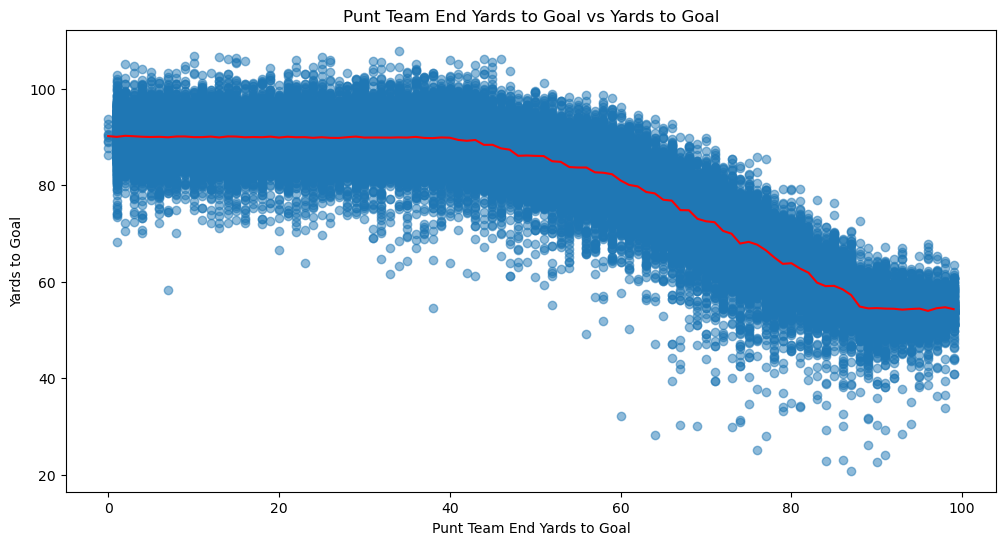

In [29]:
import matplotlib.pyplot as plt

df_ytg = pd.DataFrame(
    np.hstack([punt_data.punt_team_end_yards_to_goal.values.reshape(-1, 1), ytg]), 
    columns=['punt_team_end_yards_to_goal', 'yards_to_goal']
)

df_ytg_grouped = df_ytg.groupby('punt_team_end_yards_to_goal').agg(
    median_yards_to_goal=('yards_to_goal', 'median'),
    mean_yards_to_goal=('yards_to_goal', 'mean'),
    count=('yards_to_goal', 'count')
).reset_index()

# plot the median yards_to_goal by punt_team_end_yards_to_goal
plt.figure(figsize=(12, 6))
plt.scatter(df_ytg.punt_team_end_yards_to_goal, df_ytg.yards_to_goal, alpha=0.5)
#plot the median yards_to_goal by punt_team_end_yards_to_goal
plt.plot(df_ytg_grouped.punt_team_end_yards_to_goal, df_ytg_grouped.median_yards_to_goal, color='red', label='Median Yards to Goal')
plt.xlabel('Punt Team End Yards to Goal')
plt.ylabel('Yards to Goal')
plt.title('Punt Team End Yards to Goal vs Yards to Goal')
plt.show()

### v. Current WP Before Action

In [31]:
curr_wp_data = (
    df[[
       'score_diff','pregame_elo_diff','pct_game_played','is_home_team',
        'offense_timeouts','defense_timeouts','yards_to_goal',
    ]]
)

curr_wps = []
for model in tqdm(wp_models, desc='Predicting current win probabilities'):
    dmatrix = xgb.DMatrix(curr_wp_data)
    probas = model.predict(dmatrix).reshape(-1, 1)

    # Set WP to 1 or 0 if the game is over after the FG
    probas[(curr_wp_data['pct_game_played'] == 1.0) & ((curr_wp_data['score_diff']) > 0)] = 1.0
    probas[(curr_wp_data['pct_game_played'] == 1.0) & ((curr_wp_data['score_diff']) < 0)] = 0.0

    # round probas to 3 decimal places
    probas = np.round(probas, 3)

    curr_wps.append(probas)
    
cur_wps_matrix = np.hstack(curr_wps)

# Calculate the 5%, 50%, 95% percentiles for each sample
df['cur_win_proba_5'] = np.percentile(cur_wps_matrix, 5, axis=1)
df['cur_win_proba_50'] = np.percentile(cur_wps_matrix, 50, axis=1)
df['cur_win_proba_95'] = np.percentile(cur_wps_matrix, 95, axis=1)

Predicting current win probabilities: 100%|██████████| 100/100 [00:13<00:00,  7.53it/s]


# 4. Save the predictions data

In [68]:
# Load teams data
all_dfs = []

teams_dir = join(DATA_DIR, 'teams')
if not os.path.exists(teams_dir):
    os.makedirs(teams_dir)

for year in YEARS:
    file_path = join(teams_dir, f'{year}.parquet')
    if os.path.exists(file_path):
        print(f'Reading {file_path} from cached data')
        df_tmp = pd.read_parquet(file_path)
    else:
        print(f'Fetching {year} weather data from CFBD API')
        with cfbd.ApiClient(configuration) as api_client:
            api_instance = cfbd.GamesApi(api_client)
            data = api_instance.get_weather(year=year)
        df_tmp = pd.DataFrame([val.to_dict() for val in data])
        df_tmp.columns = convert_to_snake_case(df_tmp.columns)
        df_tmp.to_parquet(file_path)
    all_dfs.append(df_tmp)
del df_tmp

df_teams = pd.concat(all_dfs, ignore_index=True).reset_index(drop=True)
df_teams.head()

Reading ../data/teams/2013.parquet from cached data
Reading ../data/teams/2014.parquet from cached data
Reading ../data/teams/2015.parquet from cached data
Reading ../data/teams/2016.parquet from cached data
Reading ../data/teams/2017.parquet from cached data
Reading ../data/teams/2018.parquet from cached data
Reading ../data/teams/2019.parquet from cached data
Reading ../data/teams/2020.parquet from cached data
Reading ../data/teams/2021.parquet from cached data
Reading ../data/teams/2022.parquet from cached data
Reading ../data/teams/2023.parquet from cached data
Reading ../data/teams/2024.parquet from cached data


,season,id,school,mascot,abbreviation,alternate_names,conference,classification,color,alternate_color,logos,twitter,location,division
0,2013,2000,Abilene Christian,Wildcats,ACU,"[ACU, Abilene Chrstn]",FCS Independents,fcs,#592d82,#b1b3b3,[http://a.espncdn.com/i/teamlogos/ncaa/500/200...,@ACUFootball,"{'capacity': 12000.0, 'city': 'Abilene', 'cons...",None
1,2013,2005,Air Force,Falcons,AFA,"[AFA, Air Force]",Mountain West,fbs,#004a7b,#ffffff,[http://a.espncdn.com/i/teamlogos/ncaa/500/200...,@AF_Football,"{'capacity': 46692.0, 'city': 'Colorado Spring...",Mountain
2,2013,2006,Akron,Zips,AKR,"[AKR, Akron]",Mid-American,fbs,#00285e,#84754e,[http://a.espncdn.com/i/teamlogos/ncaa/500/200...,@ZipsFB,"{'capacity': 30000.0, 'city': 'Akron', 'constr...",East
3,2013,333,Alabama,Crimson Tide,ALA,"[ALA, Alabama]",SEC,fbs,#9e1632,#ffffff,[http://a.espncdn.com/i/teamlogos/ncaa/500/333...,@AlabamaFTBL,"{'capacity': 101821.0, 'city': 'Tuscaloosa', '...",West
4,2013,2010,Alabama A&M,Bulldogs,AAMU,"[AAMU, Alabama A&M]",SWAC,fcs,#790000,#ffffff,[http://a.espncdn.com/i/teamlogos/ncaa/500/201...,@AAMUFB,"{'capacity': 21000.0, 'city': 'Huntsville', 'c...",East


In [82]:
def get_team_logos(logos):
    if isinstance(logos, (list, np.ndarray)) and len(logos) > 0:
        return logos[0]
    return None

tqdm.pandas()
df_teams['logos'] = df_teams['logos'].progress_apply(get_team_logos)

  0%|          | 0/7744 [00:00<?, ?it/s]

100%|██████████| 7744/7744 [00:00<00:00, 641226.56it/s]


In [ ]:
cols = [
    'game_id','offense', 'offense_timeouts', 'defense_timeouts', 'home_id', 'home_team', 'home_division',
    'away_id', 'away_team', 'away_division', 'pregame_offense_elo', 'pregame_defense_elo',
    'offense_points_scored', 'defense_points_scored',
    'yards_to_goal','pct_game_played', 'down','distance',
    'cur_win_proba_5', 'cur_win_proba_50', 'cur_win_proba_95',
    'exp_wp_fg_5', 'exp_wp_fg_50', 'exp_wp_fg_95',
    'exp_wp_go_5', 'exp_wp_go_50', 'exp_wp_go_95',
    'exp_wp_punt_5', 'exp_wp_punt_50', 'exp_wp_punt_95',
    'decision'
]

res = (
    df[cols]
    .merge(
        df_games[['id', 'season','week','season_type']].rename(columns={'id':'game_id'}),
        how='left',
        on=['game_id']
    )
    .assign(
        offense_id=lambda x: np.where(x['offense'] == x['home_team'], x['home_id'], x['away_id']),
        offense_team=lambda x: np.where(x['offense'] == x['home_team'], x['home_team'], x['away_team']),
        offense_division=lambda x: np.where(x['offense'] == x['home_team'], x['home_division'], x['away_division']),
        defense_id=lambda x: np.where(x['offense'] == x['home_team'], x['away_id'], x['home_id']),
        defense_team=lambda x: np.where(x['offense'] == x['home_team'], x['away_team'], x['home_team']),
        defense_division=lambda x: np.where(x['offense'] == x['home_team'], x['away_division'], x['home_division']),
        wpa_fg_5=lambda x: x['exp_wp_fg_5'] - x['cur_win_proba_5'],
        wpa_go_5=lambda x: x['exp_wp_go_5'] - x['cur_win_proba_5'],
        wpa_punt_5=lambda x: x['exp_wp_punt_5'] - x['cur_win_proba_5'],
        wpa_fg_50=lambda x: x['exp_wp_fg_50'] - x['cur_win_proba_50'],
        wpa_go_50=lambda x: x['exp_wp_go_50'] - x['cur_win_proba_50'],
        wpa_punt_50=lambda x: x['exp_wp_punt_50'] - x['cur_win_proba_50'],
        wpa_fg_95=lambda x: x['exp_wp_fg_95'] - x['cur_win_proba_95'],
        wpa_go_95=lambda x: x['exp_wp_go_95'] - x['cur_win_proba_95'],
        wpa_punt_95=lambda x: x['exp_wp_punt_95'] - x['cur_win_proba_95'],
    )
    .merge(
        df_teams[['season','id','color','alternate_color','logos']]
        .rename(columns={
            'id':'offense_id', 
            'color':'offense_color', 
            'alternate_color':'offense_alternate_color',
            'logos':'offense_logos'
        }),
        how='left',
        on=['season','offense_id'],
    )
    .merge(
        df_teams[['season','id','color','alternate_color','logos']]
        .rename(columns={
            'id':'defense_id', 
            'color':'defense_color', 
            'alternate_color':'defense_alternate_color',
            'logos':'defense_logos'
        }),
        how='left',
        on=['season','defense_id'],
    )
    [[
        'season', 'week', 'season_type',
        'offense_id', 'offense_team', 'offense_division',
        'offense_color', 'offense_alternate_color', 'offense_logos',
        'defense_id', 'defense_team', 'defense_division',
        'defense_color', 'defense_alternate_color', 'defense_logos',
        'offense_timeouts', 'defense_timeouts',
        'pregame_offense_elo', 'pregame_defense_elo',
        'offense_points_scored', 'defense_points_scored',
        'yards_to_goal','pct_game_played', 'down','distance',
        'wpa_fg_5', 'wpa_fg_50', 'wpa_fg_95',
        'wpa_go_5', 'wpa_go_50', 'wpa_go_95',
        'wpa_punt_5', 'wpa_punt_50', 'wpa_punt_95',
        'decision'
    ]]
    .assign(
        recommendation=lambda x: np.select(
            [
                (x['wpa_fg_50'] > x['wpa_go_50']) & (x['wpa_fg_50'] > x['wpa_punt_50']),
                (x['wpa_go_50'] > x['wpa_fg_50']) & (x['wpa_go_50'] > x['wpa_punt_50']),
                (x['wpa_punt_50'] > x['wpa_fg_50']) & (x['wpa_punt_50'] > x['wpa_go_50']),
            ],
            [
                'fg', 'go', 'punt'
            ],
            default='wash'
        )
    )
)

res.head()

,season,week,season_type,offense_id,offense_team,offense_division,offense_color,offense_alternate_color,offense_logos,defense_id,defense_team,defense_division,defense_color,defense_alternate_color,defense_logos,offense_timeouts,defense_timeouts,pregame_offense_elo,pregame_defense_elo,offense_points_scored,defense_points_scored,yards_to_goal,pct_game_played,down,distance,wpa_fg_5,wpa_fg_50,wpa_fg_95,wpa_go_5,wpa_go_50,wpa_go_95,wpa_punt_5,wpa_punt_50,wpa_punt_95,decision,recommendation
0,2013,1,postseason,120,Maryland,fbs,#D5002B,#ffcd00,http://a.espncdn.com/i/teamlogos/ncaa/500/120.png,276,Marshall,fbs,#00ae42,#be854c,http://a.espncdn.com/i/teamlogos/ncaa/500/276.png,0.0,2.0,1921.246102,1703.121251,0.0,0.0,66,0.986111,4,4,-0.003988,-0.00598,-0.006972,-0.004240,-0.006551,-0.007990,0.00100,0.0020,0.00700,go,punt
1,2013,1,postseason,120,Maryland,fbs,#D5002B,#ffcd00,http://a.espncdn.com/i/teamlogos/ncaa/500/120.png,276,Marshall,fbs,#00ae42,#be854c,http://a.espncdn.com/i/teamlogos/ncaa/500/276.png,3.0,3.0,1921.246102,1703.121251,0.0,0.0,87,0.901944,4,5,-0.010050,-0.01150,-0.014950,-0.057899,-0.066148,-0.068128,0.04300,0.0425,0.04695,punt,punt
2,2013,1,postseason,120,Maryland,fbs,#D5002B,#ffcd00,http://a.espncdn.com/i/teamlogos/ncaa/500/120.png,276,Marshall,fbs,#00ae42,#be854c,http://a.espncdn.com/i/teamlogos/ncaa/500/276.png,3.0,3.0,1921.246102,1703.121251,0.0,0.0,68,0.369722,4,3,-0.060838,-0.06085,-0.060848,-0.130531,-0.129539,-0.124175,-0.00395,-0.0060,-0.00200,punt,punt
3,2013,1,postseason,120,Maryland,fbs,#D5002B,#ffcd00,http://a.espncdn.com/i/teamlogos/ncaa/500/120.png,276,Marshall,fbs,#00ae42,#be854c,http://a.espncdn.com/i/teamlogos/ncaa/500/276.png,3.0,3.0,1921.246102,1703.121251,0.0,0.0,97,0.114167,4,8,0.059050,0.04400,0.025000,0.048638,0.032856,0.009748,0.10905,0.1055,0.08895,punt,punt
4,2013,1,postseason,120,Maryland,fbs,#D5002B,#ffcd00,http://a.espncdn.com/i/teamlogos/ncaa/500/120.png,276,Marshall,fbs,#00ae42,#be854c,http://a.espncdn.com/i/teamlogos/ncaa/500/276.png,3.0,3.0,1921.246102,1703.121251,0.0,0.0,86,0.057500,4,18,-0.018000,-0.01900,-0.022100,0.000268,-0.004307,-0.010219,0.03605,0.0400,0.03990,punt,punt


In [88]:
PREDICTIONS_DIR = os.path.join(DATA_DIR, 'predictions')
if not os.path.exists(PREDICTIONS_DIR):
    os.makedirs(PREDICTIONS_DIR)

res.to_parquet(
    os.path.join(PREDICTIONS_DIR, 'predictions.parquet'),
    index=False
)